# Table of Contents

1.  [Introduction](#orgb0cc6ad)
2.  [Code](#orgb89be08)
    1.  [Importing libraries](#orgba6c0ab)
    2.  [Simulation Parameters](#org310ae29)
    3.  [Utility Functions and Pre-processing](#org675320d)
    4.  [Flopy Model](#orgc4c2c5f)
    5.  [Zone Budget and effect of Well](#org0fdb4cd)
3.  [Export to vtk format](#orgd3e271e)

<a id="orgb0cc6ad"></a>

# Introduction

Prairie Valley Water is installing a high-capacity well to support the expanded bottled water operations. But the company's permit is denied by the state because the state’s water withdrawal assessment tool predicted that their proposed well could adversely impact the nearby trout stream. The company argues that their well will pump deep groundwater which will have no impact on what happens at the surface. 

![img](./images/tutorial-3-site.png)

Here, we're going to make a groundwater model based on the given situation. Since we can't know for sure how much water will flow in the river and the stream as they have upstream contributions, we'll look at the rainwater contributions to the stream from the given area, and compare how much rainwater recharge to the stream when there is well compared to when there was no well.

And if the recharge to the stream is less than 5\\% of the index flow, we can say that the overall discharge on the stream will also decrease by the same amount.


<a id="orgb89be08"></a>

# Code

<a id="orgba6c0ab"></a>

## Importing libraries

Importing the libraries. Here `geometry` package from `shapely` library is being used for the defining the geometries of rivers as polygons so we can easily get the grid points that are inside it.


In [1]:
import flopy
import matplotlib.pyplot as plt
import numpy as np

from shapely import geometry

<a id="org310ae29"></a>

## Simulation Parameters

Parameters for the grids.

In [2]:
X0 = 0
XN = 7800
NC = 78
ΔX = 7800/NC

Y0 = 0
YN = 4000
NR = 40
ΔY = 4000/NR


Top = 15
Height = 220
Bottom = Top-Height

Geo Layers, these are geologically different layers, the subdivisions contains the number of divisions each of these layers will contain, and the total of that will be the actual layers used by flopy.

In [3]:
geolyr_thickness = [50, 20, 150]
geolyr_subdivisions = [10, 4, 30]

This variable will be used and if it’s true only then the well will be added to the model.

In [4]:
WELL_ON = True

Here, 2D grid is defined using numpy, we can use this for each layer and to have other informations like distances.

In [5]:
xy_grid_points = np.mgrid[X0:XN:ΔX, Y0:YN:ΔY].reshape(2, -1).T
x_grids = np.linspace(X0, XN, NC)

Here we use the geometry package to define the geometries of different zones, and well as well have any other relevant parameters that’ll be used by the model later.

In [6]:
domain = geometry.box(X0, Y0, XN, YN)
river = geometry.box(300, 0, 300+850, YN)
river_top = 10
river_height = 25
river_bottom = river_top - river_height
river_conductance = 50 * ΔX * ΔY  # leakance to conductance
stream = geometry.box(6150, 0, 6150+270, YN)
stream_top = 10.5
stream_height = 3.3
stream_conductance = 1 * ΔX * ΔY  # leakance to conductance
stream_bottom = stream_top - stream_height
well = geometry.Point((5720, 2000))
well_top = -150
well_bottom = -160
well_rate = -200 * 0.1336801*60*24  # GPM → ft³/day

<a id="org675320d"></a>

## Utility Functions and Pre-processing

Let's define a function that gives you the layers it includes if you give it the top and bottom elevation of something.

For example, if you need the layers for well, you can call this function with well screening top and bottom elevation.

This will return a generator for tuples containing the layer index, top elevation and bottom elevation. The elevations are important in case of partial covering of the layer.

In [7]:
def get_layers(top=Top, bottom=Bottom):
    all_layers = [(i, b) for i, b in enumerate(bot) if b < top]
    for i, b in all_layers:
        if b > bottom:
            yield i, top, b
        else:
            break
        top = b
    if b <= bottom:
        yield i, top, bottom

Similarly, a little more complex function to get the grid points. You can provide a shape and it'll give you the grid points, to be safe use `geometry.Polygon` shape. But you can use any shape if it has `.contains()` method.

It'll return a generator for tuples containing (lay, row, col). if layers is not given it'll return points on top most layer (index=0).

In [8]:
def get_grid_points(shape, layers=None):
    if not layers:
        layers = [0]
    else:
        layers = list(layers)
    for i, gp in enumerate(xy_grid_points):
        col = i // (NR)           # might have to swap these two.
        row = i % (NR)
        pt = geometry.Point(gp[0], gp[1])
        if shape.contains(pt):
            # layer, row, col
            for j in layers:
                yield (j, row, col)

Now we make the actual computational layers, also define a lookup array that relates computational layers to the geolayers they are part of.

`lookup_table[i]` should give `j`, where `i` is the index of computational layer and `j` is the index of geo layer.

In [9]:
# computational layers
NLay = sum(geolyr_subdivisions)
lookup_table = np.concatenate(
    list(np.ones(s, dtype=int)*i for i, s in
         enumerate(geolyr_subdivisions)))

For **implementing hetereogeiniety** in second geolayer  (index=1), we have to have different values of K in the same layer.

As we know the break in clay layer is in the same area as the river, so we'll use the grid points belonging to the river, and modify the K value of the second layer for those grid points only.

In [10]:
# hetereogeiniety in 2nd geolayer
k_2nd_layer = np.ones(shape=(NR, NC))*3.0
kv_2nd_layer = np.ones(shape=(NR, NC))*.01
for cell in get_grid_points(river):
    k_2nd_layer[cell[1], cell[2]] = 30.0
    kv_2nd_layer[cell[1], cell[2]] = 3.0

Now the overall K values for 3 geolayers will be something like this.

In [11]:
lyr_k_hz = [30.0,
            k_2nd_layer,
            150.0]
lyr_k_vt = [3.0,
            kv_2nd_layer,
            15.0]

Now to generate the data for each computational layers.

In [12]:
thickness = np.zeros(NLay)
k_hz = [0 for i in range(NLay)]
k_vt = [0 for i in range(NLay)]
bot = np.ones(NLay)

This will loop through the computational layers and then will use the lookup table to fill the values from geolayers.

In [13]:
for lay in range(NLay):
    geo_lay = lookup_table[lay]
    thickness[lay] = geolyr_thickness[geo_lay]/geolyr_subdivisions[geo_lay]
    k_hz[lay] = lyr_k_hz[geo_lay]
    k_vt[lay] = lyr_k_vt[geo_lay]
    bot[lay] = Top-sum(thickness)

Now for riv package we need to give stress period, so let’s define a function to generate the stress period data.

From the documentation we can see we need to return a tuple with (cellid, stage, cond, rbot, aux, boundname), with last 2 being optional.

We’ll use the layers falling between the river_top and bottom elevation, and then use the shape to get the grid points, for a simple model we’ll just use the same conductance value for each cell. We can modify that using how much of the river the cell contains but here rivers are polygons so let’s ignore that for now.

We’ll do the same for river and the stream and return a generator with stress period data.

In [14]:
def get_riv_stress_period():
    "gives the stress_period_data on the grid_points for river grids."

    layers_tuple = list(get_layers(top=river_top, bottom=river_bottom))
    for grid_pt in get_grid_points(river):
        for lay, thk, bottom in layers_tuple:
            # cellid, stage, cond, rbot, aux, boundname
            yield ((lay, grid_pt[1], grid_pt[2]),
                   thk, river_conductance, bottom)
    layers_tuple = list(get_layers(top=stream_top, bottom=stream_bottom))
    for grid_pt in get_grid_points(stream):
        for lay, thk, bottom in layers_tuple:
            yield ((lay, grid_pt[1], grid_pt[2]),
                   thk, stream_conductance, bottom)

Similarly, we define the stress period data for chd package, which is for constant head boundaries. We’ll use the same concept as before but return a generator for a tuple containing (cellid, head) value.

In [15]:
def get_chd_stress_period():
    "gives the stress_period_data on the grid_points for constant head points."
    # river grid points
    layers_tuple = list(get_layers(top=river_top, bottom=river_bottom))
    for grid_pt in get_grid_points(river):
        for lay, thk, bottom in layers_tuple:
            # cellid, head
            yield ((lay, grid_pt[1], grid_pt[2]), 10)

    # stream grid points
    layers_tuple = list(get_layers(top=stream_top, bottom=stream_bottom))
    for grid_pt in get_grid_points(stream):
        for lay, thk, bottom in layers_tuple:
            yield ((lay, grid_pt[1], grid_pt[2]), 10.5)

Similary, function for well stress period. Here we're trying to find the grid point closest to the well co-ordinates with same logic as in the `get_grid_points` function but for a point.

In [16]:
_gps = map(geometry.Point, xy_grid_points)
_well_gp = min(enumerate(_gps), key=lambda x: well.distance(x[1]))
well_row = _well_gp[0] % (NR)
well_col = _well_gp[0] // (NR)

def get_well_stress_period():
    well_layers = list(get_layers(well_top, well_bottom))
    return {0: [((i, well_row, well_col),
                 well_rate/len(well_layers)) for i, _, _ in
                well_layers]}

To make sure our function is working as intended, we can call it once and plot that data. Let’s plot the chd stress period data with colormap of heads.

In [17]:
sp = list(get_chd_stress_period())

ipoints = np.ones((NLay, NR, NC))
for i, _ in sp:
    ipoints[i] = -1
x = [l[0][2] for l in sp]
y = [l[0][1] for l in sp]
c = [l[1] for l in sp]

After we have the data, we can plot it.

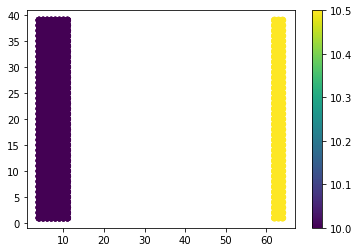

In [18]:
plt.scatter(x, y, c=c)
plt.colorbar()
plt.show()

The plot shows two patches of constant head boundaries where our river and trout streams are so it looks good.


<a id="orgc4c2c5f"></a>

## Flopy Model

Now we're ready to build the model. First things are to define the path and model name, as well as link the modflow executable.

In [19]:
ws = './models/3_water_withdrawal_controversy'
name = '3_water_wd'

sim = flopy.mf6.MFSimulation(sim_name=name,
                             sim_ws=ws,
                             exe_name='modflow-mf6')

Here we'll define `tdis`, `ims` and `gwf` packages.

In [20]:
tdis = flopy.mf6.ModflowTdis(sim,
                             time_units='days')
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

Now the discretization (`dis`) package will use the grid information to generate a grid representation.

In [21]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              length_units='FEET',
                              nlay=NLay,
                              nrow=NR,
                              ncol=NC,
                              delc=ΔX,
                              delr=ΔY,
                              top=Top,
                              botm=bot)

We'll use the top elevation as initial head, and pass that to `ic` package.

In [22]:
initial_head = np.ones((NLay, NR, NC)) * Top
ic = flopy.mf6.ModflowGwfic(gwf, strt=initial_head)

We’ll use 1ft/year of recharge, and convert it to ft/day as our units for length and time are in feet and day respectively.

We’ll also define the rivers and the conductivity with hetereogeiniety here.

In [23]:
recharge = flopy.mf6.ModflowGwfrcha(gwf, recharge=1/365)
rivers = flopy.mf6.ModflowGwfriv(
    gwf,
    stress_period_data=list(get_riv_stress_period()))
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              icelltype=1,
                              k=k_hz,
                              k33=k_vt,
                              save_specific_discharge=True)

This commented out code here shows how we can modify the values of k even after we have made the model, and we can set the data of model with out modified data.

We can use this for making that hetereogeiniety if we don’t want to do it at the beginning.

Now we'll use the previously defined functions to define the `chd` package.

In [24]:
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=list(get_chd_stress_period()))

If well is to be inserted, insert it.

In [25]:
if WELL_ON:
    wells = flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=get_well_stress_period())

Now we’ll define some files to write the output of simulation too.

In [26]:
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'),
                                        ('BUDGET', 'ALL')])

Finally, write all those details to modflow input files, and then run it.



In [27]:
sim.write_simulation()
result, _ = sim.run_simulation()

if not result:
    print("Error in Simulation")
    exit(1)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 3_water_wd...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package rcha_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 1794 based on size of stress_period_data
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1794 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /usr/local/bin/modflow-mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

  MODFLOW 6 compiled Sep 


If we encounter errors we’d have to check what we made mistakes on and repeat it. Since it’s good for now, let’s try to extract the outputs.

In [28]:
head_arr = gwf.output.head().get_data()
bud = gwf.output.budget()

chd_bud = bud.get_data(text='CHD')


spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
watertable = flopy.utils.postprocessing.get_water_table(head_arr, -1e30)


We used some postprocessing tools to get the outputs we wanted, let’s plot it and see.

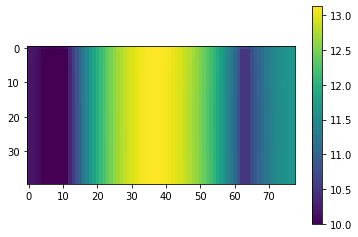

In [29]:
plt.imshow(watertable)
plt.colorbar()
plt.show()


We can see the river heads are ok, and then the heads decrease fro the middle of the simulation towards the river streams.

In [30]:
def plot_plan(ext='pdf', layer=0):
    fig, ax = plt.subplots(1, 1, figsize=(9, 3), constrained_layout=True)
    ax.set_title(f'Layer-{layer}')
    pmv = flopy.plot.PlotMapView(gwf, ax=ax)
    pmv.plot_array(head_arr[layer])
    pmv.plot_grid(colors='white', linewidths=0.3)
    pmv.contour_array(head_arr[layer],
                      linewidths=1.,
                      cmap='Wistia')
    # flopy.plot.styles.graph_legend()
    pmv.plot_vector(qx[layer, :, :], qy[layer, :, :],
                    normalize=False, istep=2, jstep=2, color="white")
    filename = f"./images/3_plan_layer-{layer}.{ext}"
    plt.savefig(filename)
    plt.show()
    return filename

In [31]:
def plot_x_section(ext='pdf', **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(9, 3), constrained_layout=True)
    # first subplot
    title_text = "; ".join((f'{k}={v}' for k, v in kwargs.items()))
    ax.set_title(f"X-Section ({title_text})")
    modelmap = flopy.plot.PlotCrossSection(
        model=gwf,
        ax=ax,
        line=kwargs,
    )
    k_values = npf.k.get_data()
    pa = modelmap.plot_array(k_values, alpha=0.6)
    quadmesh = modelmap.plot_bc("CHD")
    linecollection = modelmap.plot_grid(lw=0.2, color="white")
    minor_contours = modelmap.contour_array(
        head_arr,
        levels=np.arange(0, 25, .2),
        linewidths=0.4,
        colors='black'
    )
    contours = modelmap.contour_array(
        head_arr,
        head=head_arr,
        levels=np.arange(0, 25, 1),
        linewidths=0.8,
        colors='black'
    )
    ax.clabel(contours, fmt="%.0f")
    pv = modelmap.plot_vector(qx, qy, qz,
                              headwidth=3, headlength=4, width=2e-3,
                              pivot='mid', minshaft=2, hstep=4,
                              scale=3,
                              color='blue')
    # plt.colorbar(pa, shrink=0.5, ax=ax)
    filename = "_".join((f'{k}-{v}' for k, v in kwargs.items()))
    saveas = f"./images/3_section_{filename}.{ext}"
    plt.savefig(saveas)
    plt.show()
    return saveas

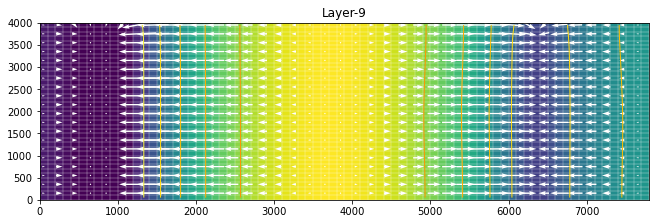

'./images/3_plan_layer-9.png'

In [32]:
plot_plan(ext='png', layer=geolyr_subdivisions[0]-1)

The first Geo-Layer. Seems similar to the plot we got when we ran the model with well turned off, so we can say the effect isn’t seen much on the top geolayer.

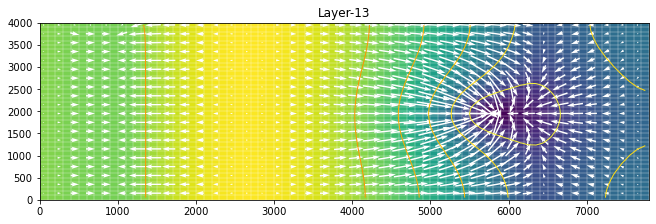

'./images/3_plan_layer-13.png'

In [33]:
plot_plan(ext='png', layer=sum(geolyr_subdivisions[:2])-1)

There seems to be some effect of well on the second geolayer.



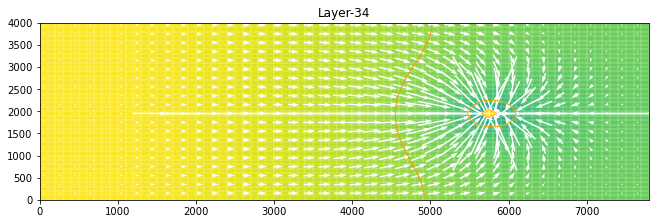

'./images/3_plan_layer-34.png'

In [34]:
lyr_index = sum(map(lambda b: b > well_bottom, bot))
plot_plan(ext='png', layer=lyr_index)

So the plot at the location of well bottom shows the cone of depression and the maximum effect.

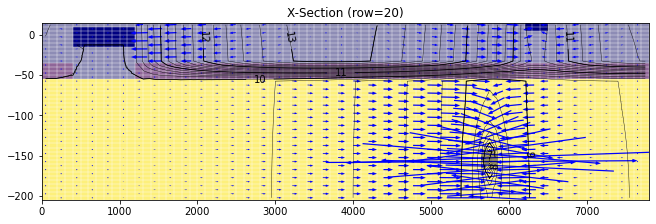

'./images/3_section_row-20.png'

In [35]:
plot_x_section(ext='png', row=20)

This section shows the effect of well and how it is mostly in the 3rd geo layer, as well as how the effect extends to the river farther away but not the trout stream. We can see the isolines move towards the river through break in the clay layer showing the effect.

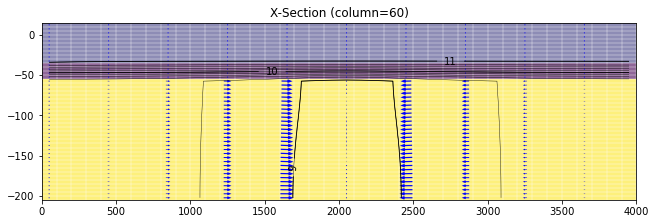

'./images/3_section_column-60.png'

In [36]:
plot_x_section(ext='png', column=60)

This column section doesn’t show much except it’s pretty much symmetric.

<a id="org0fdb4cd"></a>

## Zone Budget and effect of Well

Now let's define zone for trout stream, will use top 2 layers.

Here ZONE_2 will be the trout stream and everything else will be ZONE_1.


In [37]:
zones = np.ones((NLay, NR, NC), dtype=int)
for p in get_grid_points(stream, layers=[0, 1]):
    zones[p] = 2

we can make a zonebudget model from the previous modflow model.

In [38]:
bm = gwf.output.zonebudget(zones)

bm.change_model_name(name)
bm.change_model_ws(ws)

There seems to be a bug in write input method for budget model as I had to edit the output zbnam file to add grb file manually. So only run exisiting model files, don’t write it unless you change the zone arr, in that case write it and manually add grb file again.

In [39]:
bm.write_input()
bm.run_model(exe_name='modflow-zbud6')

FloPy is using the following executable to run the model: /usr/local/bin/modflow-zbud6
                              ZONEBUDGET Version 6
                             U.S. GEOLOGICAL SURVEY
                            VERSION 6.2.2 07/30/2021
.......

Normal Termination


(True, [])

NOTE: The `bm.write_input()` has a bug and doesn't write the grb file and it'll end up being an error. [I brought it to the attention of the developers and they've fixed it](https://github.com/modflowpy/flopy/issues/1395). But it's not yet available to the pip version 3.3.5. If the next version isn't yet released when you're running this code, then you can install the git's latest version with `pip install --upgrade git+https://github.com/modflowpy/flopy.git` in your terminal. Or manually edit it.

The .zbnam file must have following contents:

    BEGIN ZONEBUDGET
      ZON   3_water_wd.zon
      BUD   3_water_wd.bud
      GRB   3_water_wd.dis.grb
    END ZONEBUDGET

If it doesn't have it, then either do latest install from github or edit the content of the file yourself and remove the `bm.write_input()` line from the code so it won't overwrite your edits. You have to write inputs if you change zones, or your grid settings and edit the file manually again.
I'd recommend just installing the latest code from github so you don't have to.

With that we can get the water budget.

In [40]:
bm.get_budget()

rec.array([(1., 0, 0, 'DATA_SPDIS_IN',     0.        ,     0.        ),
           (1., 0, 0, 'WEL_IN',     0.        ,     0.        ),
           (1., 0, 0, 'RIV_IN',     0.        ,     0.        ),
           (1., 0, 0, 'RCH_IN', 82000.11889999,     0.        ),
           (1., 0, 0, 'CHD_IN',  1607.53625632,     0.        ),
           (1., 0, 0, 'DATA_SPDIS_OUT',     0.        ,     0.        ),
           (1., 0, 0, 'WEL_OUT', 38499.8688    ,     0.        ),
           (1., 0, 0, 'RIV_OUT',     0.        ,     0.        ),
           (1., 0, 0, 'RCH_OUT',     0.        ,     0.        ),
           (1., 0, 0, 'CHD_OUT', 24570.27139333, 20583.97502757),
           (1., 0, 0, 'FROM_ZONE_0',     0.        ,     0.        ),
           (1., 0, 0, 'FROM_ZONE_1',     0.        , 20583.97502757),
           (1., 0, 0, 'FROM_ZONE_2',     0.        ,     0.        ),
           (1., 0, 0, 'TO_ZONE_0',     0.        ,     0.        ),
           (1., 0, 0, 'TO_ZONE_1',     0.        ,   

Without well: 29121.5759986 ft³/day = 0.33705527776157407 cfs

With well: 20695.35801522 ft³/day = 0.2395296066576389 cfs

Difference 0.337 - 0.240 = 0.0975 ft³/sec

Hence the overall reduction is less than the 5% of the index flow.

Also if we also look at the reduction in the recharge to the river, we can sum both of them we get: \(5.329 × 104 - 2.459 × 104 + 2.912 × 104 - 2.070 × 104 = 37124.77086423 ft³/day\)

OR 192.86 GPM

Which is close to our well_rate = -38499.8688 ft³/day (-200 GPM).

<a id="orgd3e271e"></a>

# Export to vtk format

We can also export the heads data we obtained from the simulation and then visualize it using external tools like Paraview.

In [41]:
import os
from flopy.export import vtk
vtk.export_heads(sim.get_model(), os.path.join(ws, head_file), ws, smooth=False, kstpkper=[(0,0)], point_scalars=False, nanval=-1e30)

/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1844: UserWarning: export_heads is deprecated, use Vtk.add_heads()
  warnings.warn("export_heads is deprecated, use Vtk.add_heads()")
/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1847: UserWarning: nanval is deprecated, setting to np.nan
  warnings.warn("nanval is deprecated, setting to np.nan")
